# Analyse und Vorhersage von Stromverbrauch mit Zeitreihen und Machine Learning

## 1.Data Load

In [20]:
!pip install sklearn.metrics
!pip install pmdarima
!pip install statsmodels.tsa.seasonal
!pip install statsmodels.tsa.stattools
!pip install statsmodels.tsa.arima.model
!pip install numpy

ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for sklearn.metrics



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement statsmodels.tsa.seasonal (from versions: none)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for statsmodels.tsa.seasonal
ERROR: Could not find a version that satisfies the requirement statsmodels.tsa.stattools (from versions: none)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for statsmodels.tsa.stattools
ERROR: Could not find a version that satisfies the requirement statsmodels.tsa.arima.model (from versions: none)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np



# Data load
df = pd.read_csv(
    'household_power_consumption.csv',
    sep=';',
    parse_dates=[[0, 1]],  # Merge date and time
    na_values='?',
    infer_datetime_format=True,
    low_memory=False
)

# Rename column to datetime
df.rename(columns={'Date_Time': 'Datetime'}, inplace=True)

# Set time index
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d/%m/%Y %H:%M:%S')
df.set_index('Datetime', inplace=True)

# Columns into float type
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

df.dropna(subset=['Global_active_power'], inplace=True)

C:\Users\OsenD\AppData\Local\Temp\ipykernel_11568\1280969619.py:13: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
C:\Users\OsenD\AppData\Local\Temp\ipykernel_11568\1280969619.py:13: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
C:\Users\OsenD\AppData\Local\Temp\ipykernel_11568\1280969619.py:13: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


## 2.Basic Diagramms for Household Power Consumption

### 2.1 One Day Visualisation

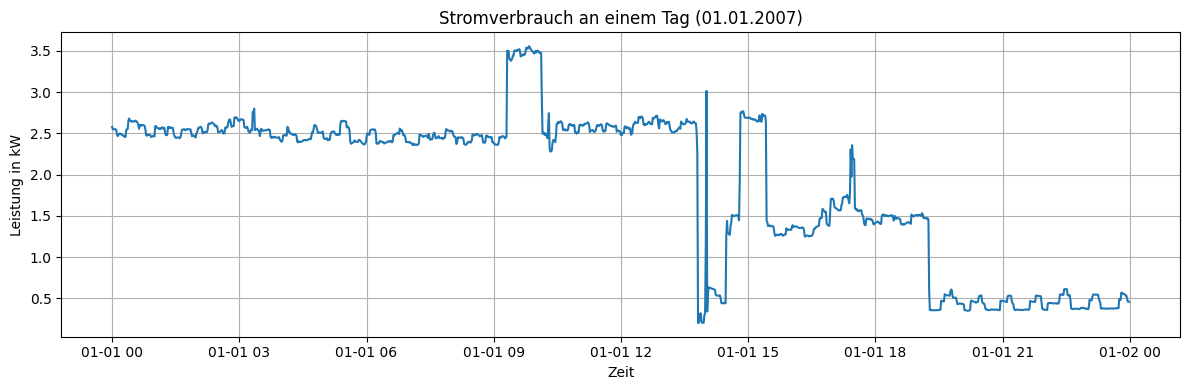

In [22]:
one_day = df.loc['2007-01-01']

plt.figure(figsize=(12, 4))
plt.plot(one_day.index, one_day['Global_active_power'], label='Global Active Power (kW)')
plt.title('Stromverbrauch an einem Tag (01.01.2007)')
plt.ylabel('Leistung in kW')
plt.xlabel('Zeit')
plt.grid(True)
plt.tight_layout()
plt.show()


Am 1. Januar 2007 lässt sich ein typischer Tagesverlauf erkennen: relativ konstante Grundlast in der Nacht, gefolgt von mehreren Verbrauchsspitzen am Vormittag und Nachmittag. Zwischen 14 und 16 Uhr sinkt der Verbrauch deutlich — möglicherweise ein Zeichen für Abwesenheit oder geringere Aktivität im Haushalt

### 2.2 One Week Visualisation

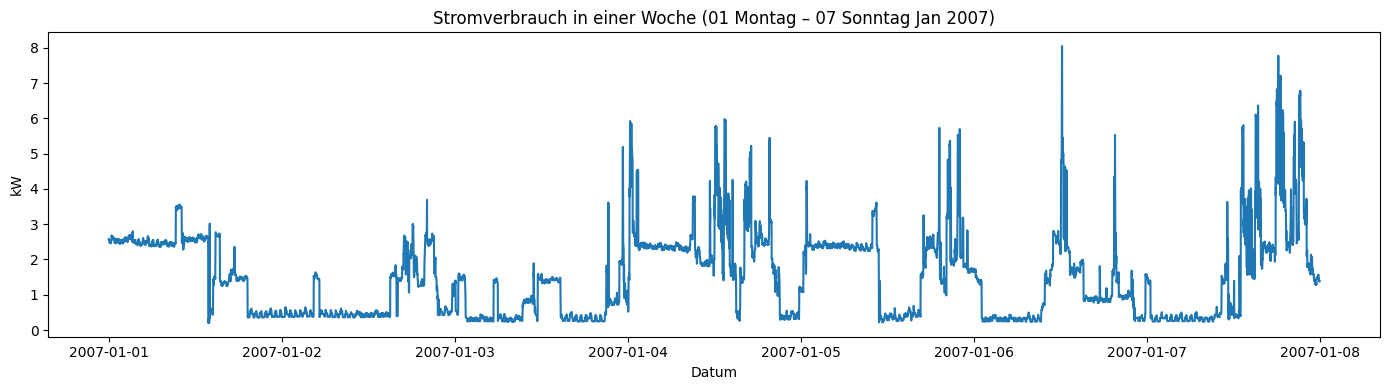

In [23]:
week = df.loc['2007-01-01':'2007-01-07']

plt.figure(figsize=(14, 4))
plt.plot(week.index, week['Global_active_power'], color='tab:blue')
plt.title('Stromverbrauch in einer Woche (01 Montag – 07 Sonntag Jan 2007)')
plt.ylabel('kW')
plt.xlabel('Datum')
plt.tight_layout()
plt.show()


In der Wochenübersicht sehen wir ein klares tägliches Muster: Verbrauchsspitzen in den Abendstunden, niedriger Verbrauch in der Nacht. Die Regelmäßigkeit deutet auf eine starke Tages-Saisonalität hin. Außerdem sehen wir am Wochenende etwas andere Verläufe – möglicherweise verändertes Verhalten

### 2.3 Moving average (trend)

Moving average of 1 hour (60 minutes)

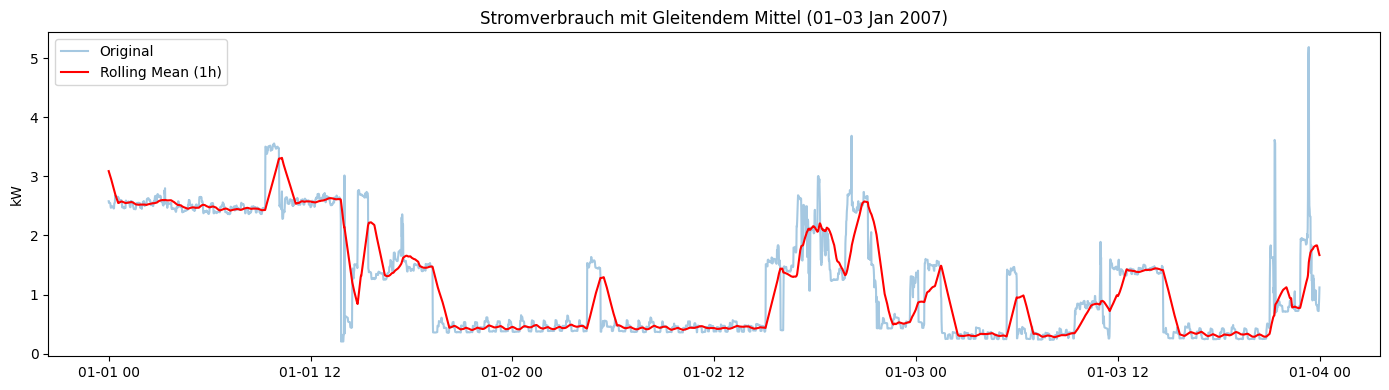

In [24]:
df['GAP_rolling'] = df['Global_active_power'].rolling(window=60).mean()

plt.figure(figsize=(14, 4))
plt.plot(df['2007-01-01':'2007-01-03']['Global_active_power'], label='Original', alpha=0.4)
plt.plot(df['2007-01-01':'2007-01-03']['GAP_rolling'], label='Rolling Mean (1h)', color='red')
plt.title('Stromverbrauch mit Gleitendem Mittel (01–03 Jan 2007)')
plt.ylabel('kW')
plt.legend()
plt.tight_layout()
plt.show()


Durch das gleitende Mittel über eine Stunde werden kurzfristige Schwankungen geglättet, sodass der allgemeine Trend und typische Verbrauchszeiten klarer sichtbar sind. Diese Methode hilft dabei, das Grundmuster für eine spätere Prognose zu erkennen.

### 2.4 Decomposition by daily consumption and **ADF Test**

<Figure size 1200x800 with 0 Axes>

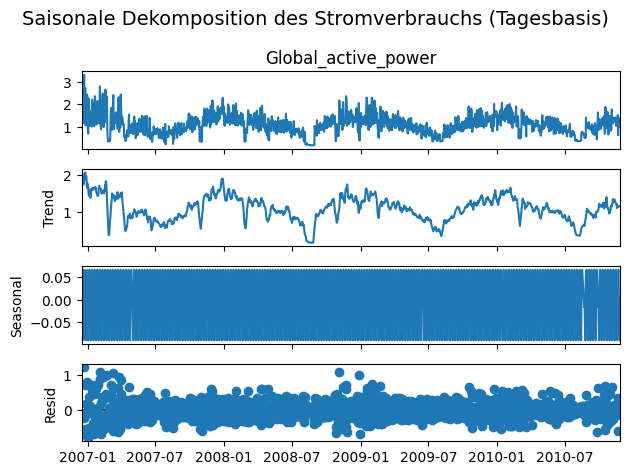

p-value: 0.004340557878211726


In [25]:
daily = df['Global_active_power'].resample('D').mean()

# Delete NaN
daily.dropna(inplace=True)

# Specify seasonal frequency: 7 is weekly seasonality
decomposition = seasonal_decompose(daily, model='additive', period=7)

# Визуализация
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Saisonale Dekomposition des Stromverbrauchs (Tagesbasis)', fontsize=14)
plt.tight_layout()
plt.show()

result = adfuller(daily)
print(f'p-value: {result[1]}')

#### p-value < 0.05 -> series is stationary -> We can use ARIMA
Mit dem Augmented Dickey-Fuller-Test (ADF-Test) prüfen wir, ob unser Zeitreihe stationär ist – also kein Trend oder saisonale Schwankungen aufweist. In unserem Fall ergibt der Test ein p-Wert von 0.0043, was kleiner als 0.05 ist. Das bedeutet: Die Zeitreihe ist stationär, und wir können direkt ein ARIMA-Modell verwenden.

## 3. ARIMA Modelling

- **AR** (AutoRegressive):
	Uses last values of the series to forecast the new value:
	 y_t=a_1 * y_(t−1) + a_2 * y(t−2) + … +ϵ_t
- **MA** (Moving Average):
	Uses errors / residuals from previous forecasts
	 y_t​=ϵ_t​+b_1 * ​ϵ_(t−1)​ + b_2 * ​ϵ_(t−2)​ + …
- **I** (Integrated):
	It means we transform the series to stationary series first (through diffentiation)

### 3.1 Test ARIMA on a small amount of data (30 days)

c:\Users\OsenD\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\OsenD\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\OsenD\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA RMSE: 0.249


c:\Users\OsenD\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\OsenD\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


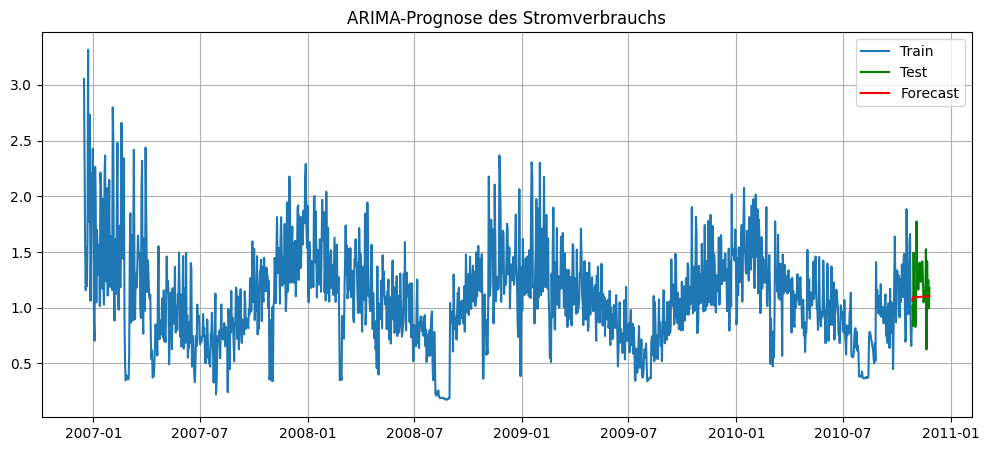

In [26]:
# Aggregated Data
daily = df['Global_active_power'].resample('D').mean()
daily.dropna(inplace=True)

# Separate to train/test
train = daily[:-30]
test = daily[-30:]

# Build Model ARIMA(p=2, d=0, q=2) without dif(I)
model = ARIMA(train, order=(2, 0, 2))
model_fit = model.fit()

# Прогнозируем
forecast = model_fit.forecast(steps=30)

# Оценим
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'ARIMA RMSE: {rmse:.3f}')

# Визуализируем
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA-Prognose des Stromverbrauchs')
plt.legend()
plt.grid(True)
plt.show()

### 3.2 ARIMA Modell

#### Modelling

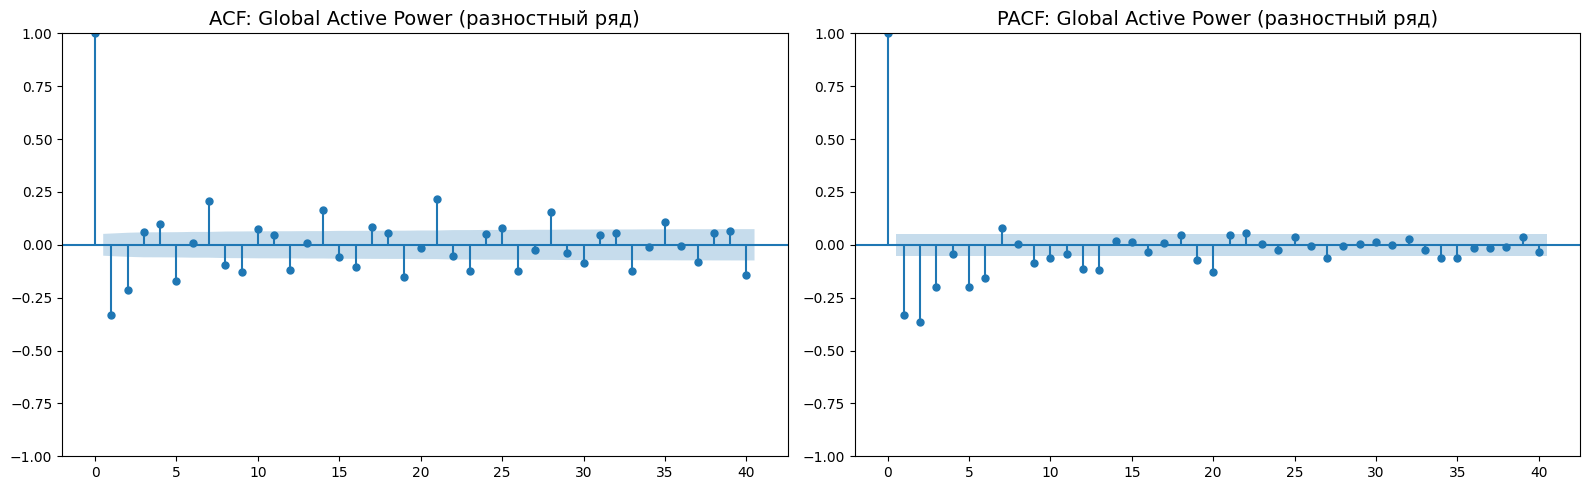

In [27]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox

# Предположим, у тебя уже есть df с 'Global_active_power' и индексом - DatetimeIndex
# Агрегируем до дневного уровня, если ещё не:
daily = df['Global_active_power'].resample('D').mean()

# Заполним пропуски линейной интерполяцией (иначе boxcox не сработает)
daily = daily.interpolate()

# Box-Cox трансформация для стабилизации дисперсии
# (λ сохраняем для обратного преобразования)
daily_boxcox, lam = boxcox(daily)

# Разностное преобразование для достижения стационарности
daily_diff = pd.Series(daily_boxcox).diff().dropna()

# Графики ACF и PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(daily_diff, ax=ax1, lags=40)
plot_pacf(daily_diff, ax=ax2, method='ywm', lags=40)
ax1.set_title('ACF: Global Active Power (разностный ряд)', fontsize=14)
ax2.set_title('PACF: Global Active Power (разностный ряд)', fontsize=14)
plt.tight_layout()
plt.show()


def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape


Train on 2008 and Test on 2009

C:\Users\OsenD\AppData\Local\Temp\ipykernel_11568\2824067458.py:6: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
C:\Users\OsenD\AppData\Local\Temp\ipykernel_11568\2824067458.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
C:\Users\OsenD\AppData\Local\Temp\ipykernel_11568\2824067458.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(
c:\Users\OsenD\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihoo

[ARIMA] MAE: 0.298, RMSE: 0.374, MAPE: 38.93%


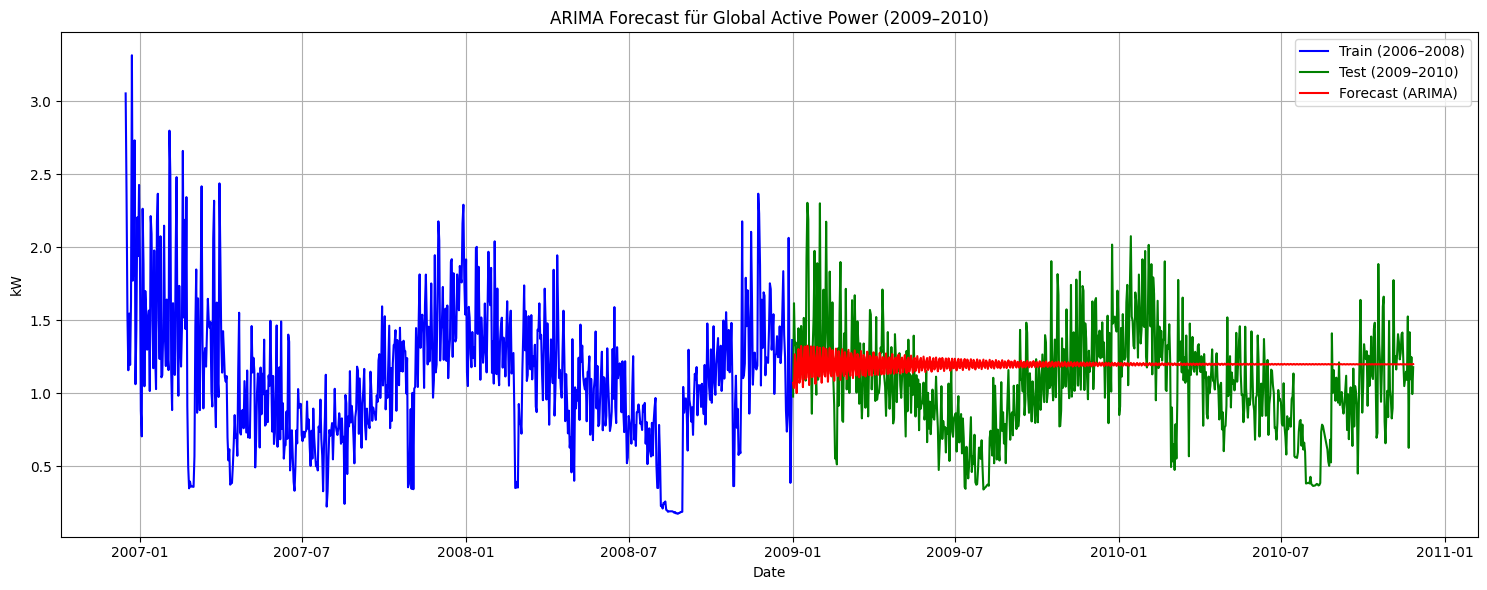

In [29]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Загрузка и подготовка
df = pd.read_csv(
    'household_power_consumption.csv',
    sep=';',
    parse_dates=[[0, 1]],
    na_values='?',
    infer_datetime_format=True,
    low_memory=False
)

df.rename(columns={'Date_Time': 'Datetime'}, inplace=True)
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df.set_index('Datetime', inplace=True)
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df[['Global_active_power']].resample('D').mean().interpolate()

# Train/test split
train_arima = df['2006-01-01':'2008-12-31']
test_arima = df['2009-01-01':'2010-11-26']

# Обучение ARIMA
model_arima = ARIMA(train_arima, order=(3,1,7))
model_fit_arima = model_arima.fit()
forecast_arima = model_fit_arima.forecast(steps=len(test_arima))

# Убедимся, что длины совпадают
forecast_arima = forecast_arima[:len(test_arima)]

# Метрики ARIMA
mae_arima, rmse_arima, mape_arima = compute_metrics(test_arima.values, forecast_arima.values)
print(f"[ARIMA] MAE: {mae_arima:.3f}, RMSE: {rmse_arima:.3f}, MAPE: {mape_arima:.2f}%")

# График
plt.figure(figsize=(15, 6))
plt.plot(train_arima.index, train_arima, label='Train (2006–2008)', color='blue')
plt.plot(test_arima.index, test_arima, label='Test (2009–2010)', color='green')
plt.plot(test_arima.index, forecast_arima, label='Forecast (ARIMA)', color='red')
plt.title('ARIMA Forecast für Global Active Power (2009–2010)')
plt.xlabel('Date')
plt.ylabel('kW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 4. SARIMA Modell

C:\Users\OsenD\AppData\Local\Temp\ipykernel_11568\1565984003.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sarima.dropna(inplace=True)
C:\Users\OsenD\AppData\Local\Temp\ipykernel_11568\1565984003.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sarima.dropna(inplace=True)
c:\Users\OsenD\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\OsenD\AppData\Local\Programs\Python\Python3

[SARIMA] MAE: 0.523, RMSE: 0.632, MAPE: 49.62%


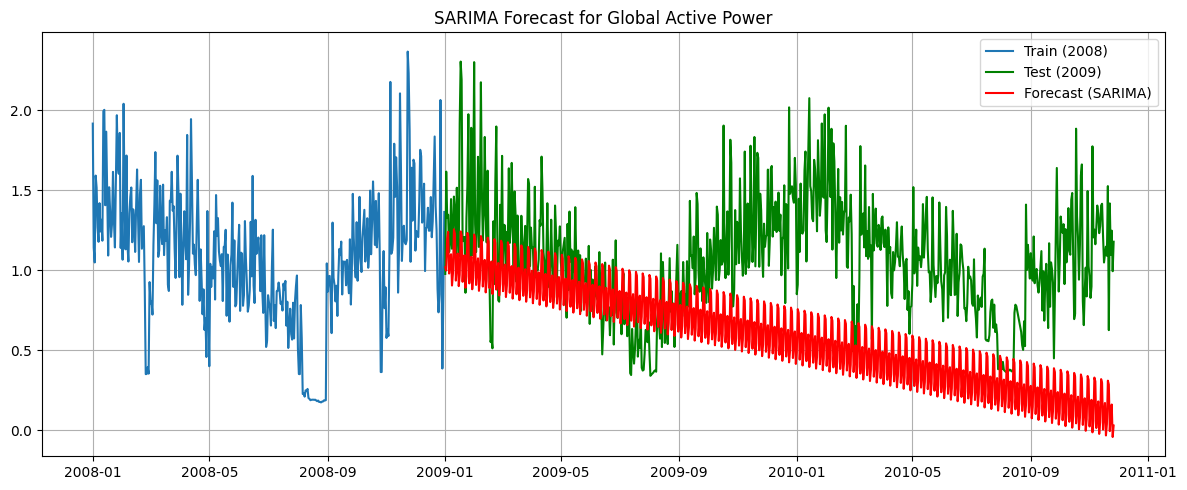

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train/test split
train_sarima = df['2008-01-01':'2008-12-31']
test_sarima = df['2009-01-01':'2010-11-26']

train_sarima.dropna(inplace=True)
test_sarima.dropna(inplace=True)

# SARIMA модель
model_sarima = SARIMAX(train_sarima, order=(2, 1, 2), seasonal_order=(1, 1, 1, 7))
model_fit_sarima = model_sarima.fit(disp=False)
forecast_sarima = model_fit_sarima.forecast(steps=len(test_sarima))

# Убедимся, что длины совпадают
forecast_sarima = forecast_sarima[:len(test_sarima)]

# Метрики SARIMA
mae_sarima, rmse_sarima, mape_sarima = compute_metrics(test_sarima.values, forecast_sarima.values)
print(f"[SARIMA] MAE: {mae_sarima:.3f}, RMSE: {rmse_sarima:.3f}, MAPE: {mape_sarima:.2f}%")

# Визуализация
plt.figure(figsize=(12, 5))
plt.plot(train_sarima.index, train_sarima, label='Train (2008)')
plt.plot(test_sarima.index, test_sarima, label='Test (2009)', color='green')
plt.plot(test_sarima.index, forecast_sarima, label='Forecast (SARIMA)', color='red')
plt.title('SARIMA Forecast for Global Active Power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
